## Two qubit QAOA with Kerr resonators

In [3]:
import numpy as np; pi = np.pi
from qutip import *
from qutip.qip.circuit import QubitCircuit
from qutip.qip.operations import *
from qaoa_with_cat_qubits.cvdevice import KPOProcessor
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Figures should have a width of a 8.6 cm or 3 3/8 in, the width of a single manuscript column.
golden_mean = (np.sqrt(5)-1.0)/2.0 # Aesthetic ratio
fig_width = (3+3/8) # width in inches
fig_height = fig_width*golden_mean # height in inches (0.75 is the standard height to width ratio in Python)
fig_size = [fig_width, fig_height]
mpl.rcParams.update({
    'axes.labelsize' : 9,
    'font.size' : 9,
    'legend.fontsize' : 8,
    'xtick.labelsize' : 8,
    'ytick.labelsize' : 8,
    'ytick.minor.pad' : -0.5,
    'ytick.minor.pad' : -0.5,
    'ytick.major.size' : 2,
    'ytick.minor.size' : 2,
    'ytick.major.width' : .5,
    'ytick.minor.width' : .5,
    'xtick.major.size' : 2,
    'xtick.minor.size' : 2,
    'xtick.major.width' : .5,
    'xtick.minor.width' : .5,
    'xtick.major.pad' : 1.5,
    'xtick.minor.pad' : 1.5,
    'text.usetex' : False,
    'figure.dpi' : 100,
})

initialize problem

In [5]:
# Problem
J = -1*np.array([[1,1/2],[1/2,1/2]])
h = -1*np.array([1/2,0])

# Eigvals [2 1 0 1]

# Number of qubits in the system
N = 2

H_cost = - J[0,1]*tensor(sigmaz(),sigmaz()) - h[0]*tensor(sigmaz(),qeye(2)) + 1
H_cost

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[2. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]]

setup parameters

In [6]:
kpo = KPOProcessor(N = N, num_lvl = 12)
alpha = kpo._paras['Coherent state']
num_lvl = kpo._paras['Cut off']
eye = qeye(num_lvl)

# Cat state
cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

# computational basis
up = (cat_plus + cat_minus)/np.sqrt(2) # Binary 0
down = (cat_plus - cat_minus)/np.sqrt(2) # Binary 1

# pauli-z
sigma_z = ket2dm(up) - ket2dm(down)
identity = ket2dm(up) + ket2dm(down)

# possible initial states
plus = cat_plus
iplus = (cat_plus + 1j*cat_minus)/np.sqrt(2)

# initial state
initial_state = tensor([plus for i in range(N)])

create Hamiltonian

In [7]:
H = - J[0,1]*tensor(sigma_z,sigma_z) - h[0]*tensor(sigma_z,identity)

project Hamiltonian to computational basis

In [8]:
ket00 = tensor(up,up)
ket10 = tensor(down,up)
ket01 = tensor(up,down)
ket11 = tensor(down,down)
cost = np.zeros((4,4))
cost[0,0] = (H*ket2dm(ket00)).tr()
cost[1,1] = (H*ket2dm(ket01)).tr()
cost[2,2] = (H*ket2dm(ket10)).tr()
cost[3,3] = (H*ket2dm(ket11)).tr()
Qobj(cost) + 1

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[2. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]]

In [9]:
# Iteration level
p = 1

if p == 1:
    # Angles p = 1
    alphas = [0.9046]
    betas = [2.6893]
    # 100 % with Y-mixer, initial-state?
    #gamma = [np.pi]
    #beta = [2.3562]
elif p == 2:
    # Angles p = 2
    alphas = [pi/2, pi/2]
    betas = [2.3562, 2.3562]

Optimize angles

In [10]:
alphas = [1.57366196, 1.58287706]
betas = [2.07638867, 2.08759741]

Construct Ising-ZZ gate

In [11]:
def carb(arg_value):
    # control arbitrary phase gate
    zz = tensor(sigmaz(),sigmaz())
    return (-1j*arg_value/2*zz).expm()

Construct qaoa circuit

In [12]:
def qaoa_circuit(params):
    alphas, betas = params
    
    # Representation of a quantum program/algorithm, maintaining a sequence of gates.
    qc = QubitCircuit(N = N, reverse_states = False)
    qc.user_gates = {"CARB": carb}
    qc.add_state(state = "+", targets = range(N), state_type = "input")
    
    for alpha,beta in zip(alphas,betas):
        for j in range(N-1):
            for k in range(j+1,N):
                if J[j][k] != 0:
                    qc.add_gate("CARB", targets = [j,k], arg_value = 2*alpha*J[j][k])
        for j in range(N):
            if h[j] != 0:
                qc.add_gate("RZ", j, None, 2*alpha*h[j])
            if 2*beta > np.pi:
                qc.add_gate("RX", j, None, 2*np.pi - 2*beta)
    return qc

In [13]:
def cost_fun(x):
    lvl = int(len(x)/2)
    alphas = x[:lvl]
    betas = x[lvl:]
    params = (alphas, betas)
    # simulate
    result = kpo.run_state(init_state = initial_state, qc = qaoa_circuit(params), noisy = True)
    final_state = result.states[-1]
    if final_state.type == 'ket':
        final_state = ket2dm(final_state)
    return (H*final_state).tr().real

Load the circuit onto the device

In [14]:
kpo = KPOProcessor(N = N)
params = (alphas,betas)
tlist, coeffs = kpo.load_circuit(qaoa_circuit(params))
print("Total time = %s (1/K)" % round(tlist[-1]))

Total time = 28 (1/K)


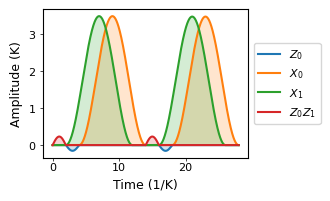

In [15]:
fig = kpo.plot_pulses(figsize=fig_size)

In [ ]:
plt.savefig('fig-qaoa-level-1-pulses-rx-mixer.pdf', dpi=300, transparent=False, bbox_inches='tight')

### Setup parameters and initial values

In [16]:
kpo = KPOProcessor(N = 2)
alpha = kpo._paras['Coherent state']
num_lvl = kpo._paras['Cut off']
eye = qeye(num_lvl)

# Cat state
cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

# computational basis
up = (cat_plus + cat_minus)/np.sqrt(2) # Binary 0
down = (cat_plus - cat_minus)/np.sqrt(2) # Binary 1

# pauli-z
sigma_z = ket2dm(up) - ket2dm(down)
identity = ket2dm(up) + ket2dm(down)

# possible initial states
plus = cat_plus
iplus = (cat_plus + 1j*cat_minus)/np.sqrt(2)

# initial state
initial_state = tensor([plus for i in range(N)])

### Load optimal params

In [18]:
res = np.load('../../data/two_qubit_qaoa/two-qubit-qaoa-rx-mixer-2.npy', allow_pickle=True)
data = res.all()
x = data.x
alphas = x[:2]
betas = x[2:]

/Users/turbotanten/Documents/GitHub/QAOA-with-Cat-Qubits/envs/myenv/lib/python3.8/site-packages/numpy/lib/format.py:781: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  array = pickle.load(fp, **pickle_kwargs)


In [19]:
res

array(  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.8771151909723817
        x: [ 1.562e+00  1.557e+00  2.347e+00  2.350e+00]
      nit: 15
      jac: [ 9.202e-03  1.922e-06  3.271e-06 -4.061e-06]
 hess_inv: [[ 9.023e-06 -6.950e-04 -5.411e-04 -5.401e-05]
            [-6.950e-04  1.315e+00  3.527e-01  3.318e-02]
            [-5.411e-04  3.527e-01  2.653e-01 -1.606e-02]
            [-5.401e-05  3.318e-02 -1.606e-02  1.865e-01]]
     nfev: 381
     njev: 74, dtype=object)

In [20]:
params = (alphas,betas)
tlist, coeffs = kpo.load_circuit(qaoa_circuit(params))

### Run master equation

In [21]:
# simulate
result = kpo.run_state(init_state = initial_state, noisy = True)
final_state = result.states[-1]

In [ ]:
final_state

In [ ]:

qsave(final_state,'results/noisy-qaoa-level-2-rx-mixer0')

In [4]:
final_state = qload('results/noisy-qaoa-level-2-rx-mixer0')

FileNotFoundError: [Errno 2] No such file or directory: 'results/noisy-qaoa-level-2-rx-mixer0.qu'

### Calculate success probability

In [47]:
target_state = tensor(down,up)
if final_state.type == 'ket':
    f = (target_state.dag() * final_state).full()[0][0]
    f = abs(f)**2
else:
    f = (ket2dm(target_state) * final_state).tr().real
print("Success Probability = %s %%" % round(f*100,3))

Success Probability = 90.639 %


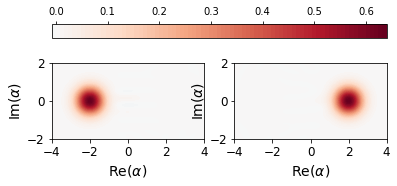

In [15]:
q0 = final_state.ptrace(0)
q1 = final_state.ptrace(1)
xvec = np.linspace(-4, 4, 400); yvec = np.linspace(-2, 2, 200)
W0 = wigner(q0,xvec,yvec,'iterative',2)
W1 = wigner(q1,xvec,yvec,'iterative',2)
nrm = mpl.colors.Normalize(-W0.max(), W0.max()) # Normalize colors

# contour plot
plt.subplot(121,aspect='equal')
im = plt.contourf(xvec, yvec, W0, 100, cmap = cm.RdBu_r, norm = nrm) # density plot
plt.xlabel(r'Re$(\alpha)$', fontsize = 14)
plt.ylabel(r'Im$(\alpha)$', fontsize = 14)
plt.xticks(np.arange(min(xvec),max(xvec)+1,2),fontsize = 12)
plt.yticks(np.arange(min(yvec),max(yvec)+1,2),fontsize = 12)

# contour plot
plt.subplot(122,aspect='equal')
im = plt.contourf(xvec, yvec, W1, 100, cmap = cm.RdBu_r, norm = nrm) # density plot
plt.xlabel(r'Re$(\alpha)$', fontsize = 14)
plt.ylabel(r'Im$(\alpha)$', fontsize = 14)
plt.xticks(np.arange(min(xvec),max(xvec)+1,2),fontsize = 12)
plt.yticks(np.arange(min(yvec),max(yvec)+1,2),fontsize = 12)

# colorbar
cax = plt.axes([0.125, 0.72, 0.775, 0.05]) # left, bottom, width, height
plt.colorbar(im, cax = cax, orientation = 'horizontal', ticklocation = 'top', ticks = np.arange(round(W0.min())-1,round(W0.max()+.1)+.1,0.1));

## <a name="Ry">QAOA but with a $R_y$-gate</a>

In [31]:
def carb(arg_value):
    # control arbitrary phase gate
    zz = tensor(sigmaz(),sigmaz())
    return (-1j*arg_value/2*zz).expm()

# Iteration level
p = 1

if p == 1:
    # Angles p = 1 100% success
    #gamma = [np.pi]
    #beta = [0.7823]
    # angles p = 1 50% success
    gamma = [0.8999]
    beta = [2.6838]
    gamma = [0.9046]
    beta = [2.6893]
elif p == 2:    
    # Angles p = 2
    # Angles p = 2
    gamma = [pi/2, pi/2]
    beta = [2.3562, 2.3562]

# Representation of a quantum program/algorithm, maintaining a sequence of gates.
qc = QubitCircuit(N = N, reverse_states = False)
qc.user_gates = {"CARB": carb}
qc.add_state(state = "+", targets = range(N), state_type = "input")

for i in range(p):
    for j in range(N-1):
        for k in range(j+1,N):
            if J[j][k] != 0:
                qc.add_gate("CARB", targets = [j,k], arg_value = 2*gamma[i]*J[j][k])
    for j in range(N):
        if h[j] != 0: 
            qc.add_gate("RZ", j, None, 2*gamma[i]*h[j])
        qc.add_gate("RY", j, None, 2*beta[i])

In [32]:
kpo = KPOProcessor(N = N)
tlist, coeffs = kpo.load_circuit(qc)
print("Total time = %s (1/K)" % round(tlist[-1]))

Total time = 9 (1/K)


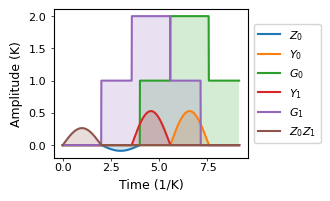

In [33]:
fig = kpo.plot_pulses(figsize=fig_size)
plt.savefig('fig-qaoa-pulses-level-1-ry-mixer.pdf', dpi=300, transparent=False, bbox_inches='tight')

## Setup parameters and initial values

In [21]:
alpha = kpo._paras['Coherent state']
num_lvl = kpo._paras['Cut off']
eye = qeye(num_lvl)

# computational basis
up = coherent(num_lvl, alpha) # logical zero
down = coherent(num_lvl,-alpha) # logical one

# initial state
plus = (up-1j*down).unit()
psi0 = tensor([plus for i in range(N)])

## Run master equation

In [22]:
# simulate
result = kpo.run_state(init_state = psi0, noisy = True)
final_state = result.states[-1]

KeyboardInterrupt: 

In [125]:
qsave(final_state, 'results/noisy-qaoa-level-2-ry-mixer')

## Calculate success probability

In [ ]:
target_state = tensor(down,up)
if final_state.type == 'ket':
    f = (target_state.dag() * final_state).full()[0][0]
    f = abs(f)**2
else:
    f = abs((target_state.dag() * final_state * target_state).full()[0][0])
print("Success Probability = %s %%" % round(f*100,3))